The overall issue of modern portfolio theory: although the covariances of a few assets can be adequately estimated, it is difficult to come up with reasonable estimates of expected returns.

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
from dotenv import load_dotenv

from utils import get_factors, get_monthly_returns, get_stock_details, get_portfolio_weights, select_factor_list, visualize_returns
from helpers import run_regression, compute_annual_return, get_insights, forecast_factors, compute_monthly_expected_returns

load_dotenv()

True

We want to explain our portfolio, or single stock, using factors defined by the a series of linear models that relates the expected return of a stock to several historical factors of the market. The most simple of these is the CAPM model, which aims to relate the expected return of an asset to the the expected return of the market. The model is defined as follows:

$$
E[R_i] = R_f + \beta_i (E[R_m] - R_f)
$$

Where:
- $E[R_i]$ is the expected return of the stock
- $R_f$ is the risk-free rate
- $\beta_i$ is the beta of the stock
- $E[R_m]$ is the expected return of the market

The beta of a stock is a measure of the stock's volatility in relation to the market. A beta of 1 means that the stock moves in line with the market. A beta greater than 1 means that the stock is more volatile than the market, and a beta less than 1 means that the stock is less volatile than the market.

In our case, we will grab the market excess returns from the Kenneth French data library.

This same model is used extended by the Fama-French 3 factor model, which adds two more factors to the model. The Fama-French model is defined as follows:

$$
E[R_i] = R_f + \beta_i (E[R_m] - R_f) + s_i SMB + h_i HML
$$

Where:
- $s_i$ is the stock's exposure to the size factor
- $SMB$ is the size factor, which measures the difference in returns between small and large cap stocks over the specified period
- $h_i$ is the stock's exposure to the value factor
- $HML$ is the value factor, which measures the difference in returns between value and growth stocks over the specified period

This model can be extended further to the Fama-French 5 factor model, which adds two more factors to the model. The Fama-French 5 factor model is defined as follows:

$$
E[R_i] = R_f + \beta_i (E[R_m] - R_f) + s_i SMB + h_i HML + r_i RMW + c_i CMA
$$

Where:
- $r_i$ is the stock's exposure to the profitability factor
- $RMW$ is the profitability factor, which measures the difference in returns between high and low profitability stocks over the specified period, based on their earnings
- $c_i$ is the stock's exposure to the investment factor
- $CMA$ is the investment factor, which measures the difference in returns between stocks that reinvest a high amount vs a lower amount over the specified period

[*********************100%%**********************]  1 of 1 completed


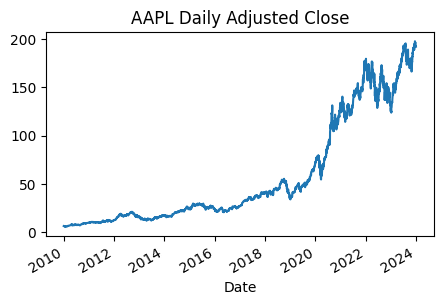

,Adj Close,Return
Date,,
2010-02,6.178447,6.539629
2010-03,7.095764,14.847038
2010-04,7.883545,11.102141
2010-05,7.756425,-1.612473
2010-06,7.594883,-2.082685
...,...,...
2023-08,187.129883,-4.238391
2023-09,170.535538,-8.867822
2023-10,170.097260,-0.257001


In [2]:
# As an example, we will use the stock of Apple Inc. (AAPL)
returns = yf.download("AAPL", start="2010-01-01", end="2023-12-31")
returns["Adj Close"].plot(title="AAPL Daily Adjusted Close", figsize=(5, 3))
plt.show()

# calculate daily returns of QQQ
# data = returns["Adj Close"].to_frame()
# data["Return"] = data["Adj Close"].pct_change() * 100
# data.dropna(inplace=True)
# data

data = returns["Adj Close"].resample("ME").ffill().to_frame()
data.index = data.index.to_period("M")
data["Return"] = data["Adj Close"].pct_change() * 100
data.dropna(inplace=True)
data

In [12]:
# tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "NVDA", "PYPL", "ADBE", "NFLX"]
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "CLF"]
initial_amount = 10000
start_date = "2010-01-01"
end_date = "2023-12-31"
model_type = "ff3" # Either capm, ff3, or ff5
strategy = "srp"

In [13]:
factors_monthly = get_factors()
factor_list = select_factor_list(model_type)
factors_subset = factors_monthly[factors_monthly.index.isin(data.index)].copy()

In [14]:
weights = get_portfolio_weights(tickers, strategy=strategy, start_date=start_date, end_date=end_date, l=5, rf=factors_subset["RF"].mean())
# We will also take the data of a portfolio with weights
portfolio = get_monthly_returns(tickers, start_date, end_date)
portfolio_return = (portfolio * weights).sum(axis=1)

factors_subset["Excess Returns"] = portfolio_return - factors_subset["RF"]

if len(tickers) != len(weights):
    raise ValueError("Number of tickers and weights must be equal")

[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

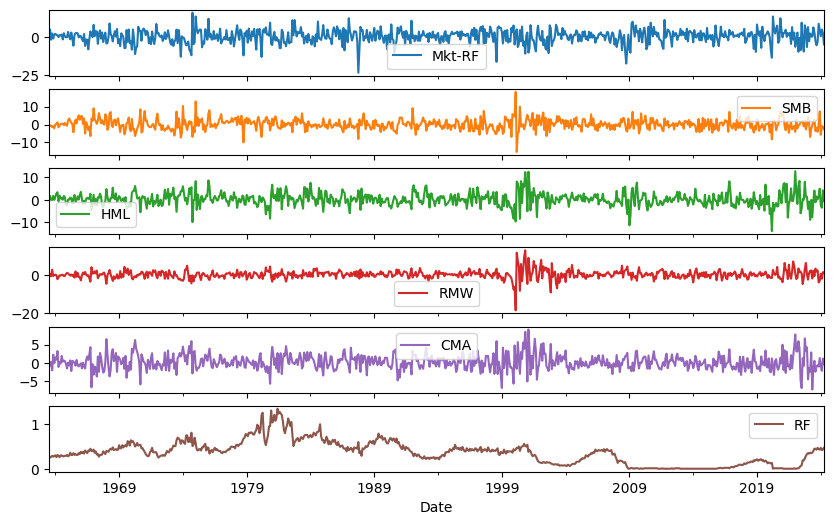

In [15]:
# Plot factors across time
factors_monthly.plot(subplots=True, figsize=(10, 6))

<Axes: title={'center': 'Portfolio Monthly Returns'}, xlabel='Date'>

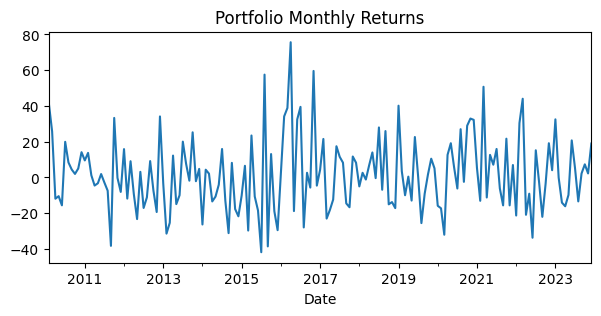

In [16]:
# Plot portfolio returns
portfolio_return.plot(title="Portfolio Monthly Returns", figsize=(7, 3))

In [17]:
# X = sm.add_constant(factors_subset[["Mkt-RF"]]) # CAPM model
# X = sm.add_constant(factors_subset[["Mkt-RF", "SMB", "HML"]]) # Fama-French 3-factor model
# X = sm.add_constant(factors_subset[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]) # Fama-French 5-factor model
# y = factors_subset["Excess Returns"]
# model = sm.OLS(y, X).fit()
# model.summary()
model = run_regression(factors_subset, factor_list)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Excess Returns   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     17.80
Date:                Thu, 01 Aug 2024   Prob (F-statistic):           4.85e-10
Time:                        23:08:54   Log-Likelihood:                -716.41
No. Observations:                 167   AIC:                             1441.
Df Residuals:                     163   BIC:                             1453.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1365      1.430     -0.095      0.924      -2.961       2.688
Mkt-RF         1.7263      0.336      5.139      0.000       1.063       2.390
SMB            1.1202      0.584      1.918      0.057      -0.033       2.274
HML            0.8997      0.438      2.055      0.042       0.035       1.764
==============================================================================
Omnibus:                       22.110   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.389
Skew:                           0.755   Prob(JB):                     1.53e-07
Kurtosis:                       4.494   Cond. No.                         4.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now that we have built our regression model, we can visualize how each coefficient affects the expected return of the stock.

/opt/homebrew/Caskroom/miniconda/base/envs/quant/lib/python3.9/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


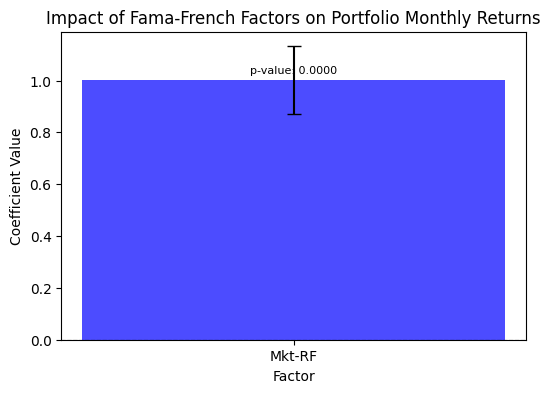

In [8]:
# Extract the coefficients and confidence intervals
factors = model.params.index[1:]  # ['Mkt_Rf', 'SMB', 'HML']
coefficients = model.params.values[1:]
confidence_intervals = model.conf_int().iloc[1:]

ols_data = pd.DataFrame({
    "Factor": factors,
    "Coefficient": coefficients,
    "Confidence_Lower": confidence_intervals[0],
    "Confidence_Upper": confidence_intervals[1],
    "P-Value": model.pvalues[1:]
})

# Plotting for visual confirmation
plt.figure(figsize=(6, 4))

bars = plt.bar(ols_data["Factor"], ols_data["Coefficient"], color='blue', alpha=0.7, capsize=10)
plt.errorbar(
    ols_data["Factor"],
    ols_data["Coefficient"],
    yerr=[
        ols_data["Coefficient"] - ols_data["Confidence_Lower"],
        ols_data["Confidence_Upper"] - ols_data["Coefficient"]
    ],
    fmt='none',
    capsize=5,
    color='black'
)

# Add the p-value for each factor to the plot
for i, row in ols_data.iterrows():
    plt.text(
        i,
        row['Coefficient'] + 0.02,  # Position text slightly above the bar
        f"p-value: {row['P-Value']:.4f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.title("Impact of Fama-French Factors on Portfolio Monthly Returns")
plt.xlabel("Factor")
plt.ylabel("Coefficient Value")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.show()

In [9]:
client = OpenAI()

# Analyze the OLS regression results using GPT-4
stock_details = get_stock_details(tickers)
insights = get_insights(client, ols_data, portfolio=portfolio_return, stock_details=stock_details, advanced=False)
print("Insights from GPT-4o:\n", insights)

Insights from GPT-4o:
 ### Analyzing the Regression Results

The regression output focuses on a key factor, "Mkt-RF," which often represents the market return in a finance context, less the risk-free rate. Here's a breakdown of the provided regression results:

- **Coefficient**: The coefficient for "Mkt-RF" is approximately **1.001**, indicating that for every 1% increase in excess market returns (over the risk-free rate), the dependent variable—likely representing the portfolio's return—has also increased by approximately 1%. This suggests a strong positive relationship between the market movements and the portfolio's results.

- **Confidence Interval**: The confidence interval (0.870 to 1.132) indicates that we can be very confident that the true effect of market returns on the portfolio return falls within this range. The proximity of the coefficient to 1 suggests that the portfolio is highly correlated with market movements.

- **P-Value**: The P-value is exceedingly low (5.13e-33

In [9]:
# Example usage
forecasted_factors = forecast_factors(factors_monthly, model_type=model_type, steps=12)
monthly_expected_returns = compute_monthly_expected_returns(model, forecasted_factors)
annual_expected_return = compute_annual_return(monthly_expected_returns)

# print(monthly_expected_returns)
print("Expected Annual Return for the Next 12 Months: {:.2f}%".format(annual_expected_return * 100))


Expected Annual Return for the Next 12 Months: 15.72%


[3.6405551163783745, -3.766519761611408, 4.691347407141066, 5.00315292915025, 3.562078917069191, 0.4290429161871211, 4.02129713617049, -3.3374239875554035, 1.8685785696480743, 1.519478100261217, 0.7936473882147981, -2.385138288971661, 2.8006369320468396]


/var/folders/1c/l83jhl7n1bd87zvyz_7r6p6h0000gp/T/ipykernel_15589/1931412993.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_returns = [historical_returns[-1]] + forecasted_returns


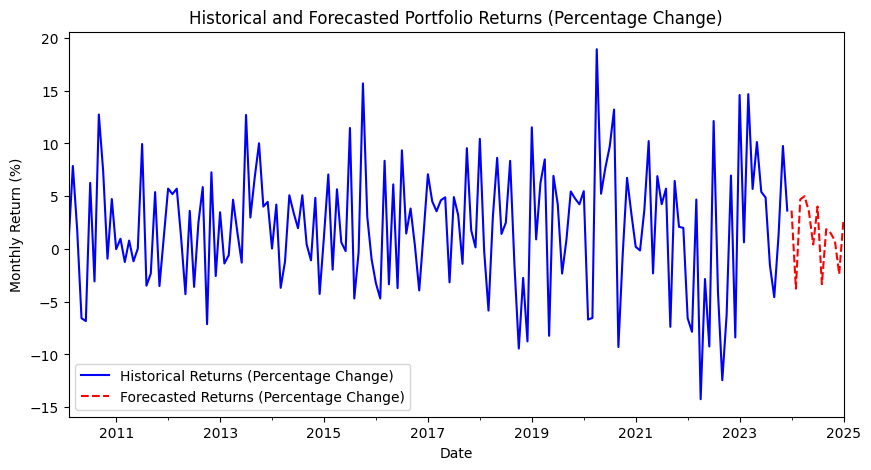

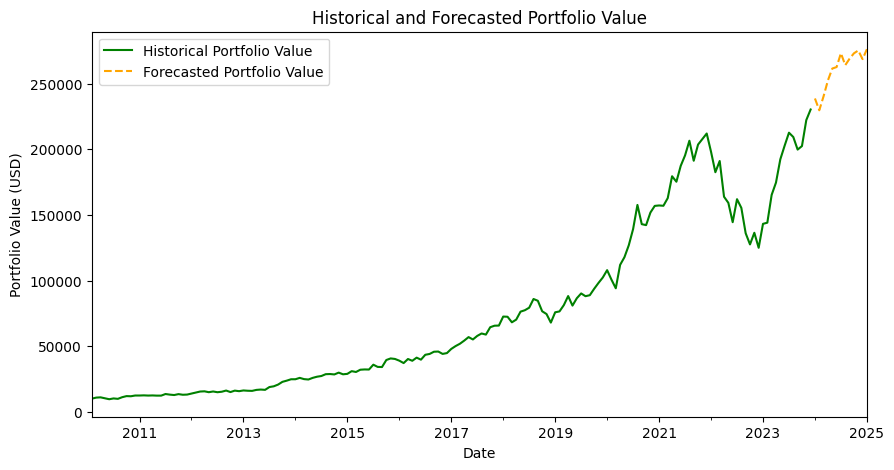

In [15]:
portfolio_return = (portfolio * weights).sum(axis=1)
# print(portfolio, weights)
visualize_returns(portfolio_return, monthly_expected_returns, initial_amount)